# **Data Collecting**

## Library

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc, classification_report
) #import metric untuk evaluate

import warnings
warnings.filterwarnings('ignore') #supaya nggak semak

## Load

In [341]:
df = pd.read_csv("dataset/water_quality_potability_v2.csv")
df = df[['ph', 'Solids', 'Turbidity', 'Potability']]
df["Solids"] = (df["Solids"] / 62000) * 1000

display(df[df['Solids'] > 600])
df

,ph,Solids,Turbidity,Potability
16,3.722500,612.293032,3.662838,0
136,5.323816,606.866979,2.880722,0
170,6.106760,635.972707,3.924967,0
308,7.294364,670.483097,3.336582,0
384,6.800119,631.345215,3.854940,1
...,...,...,...,...
13226,7.870853,834.384202,4.221614,1
13236,4.767472,774.320454,3.893378,1
13250,7.371914,678.377104,4.338957,1
13256,7.607224,632.013657,3.525027,1


,ph,Solids,Turbidity,Potability
0,7.160466,365.109446,3.991681,1
1,7.187738,342.952066,3.957064,0
2,5.400302,278.493442,4.824786,0
3,7.078913,347.406221,3.909317,0
4,7.052283,349.346270,3.989340,0
...,...,...,...,...
13271,4.668102,767.435348,4.435821,1
13272,7.808856,279.512938,2.798243,1
13273,9.419510,534.767391,3.298875,1
13274,5.126763,193.288216,4.708658,1


In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13276 entries, 0 to 13275
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          12785 non-null  float64
 1   Solids      13276 non-null  float64
 2   Turbidity   13276 non-null  float64
 3   Potability  13276 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 415.0 KB


In [343]:
df.describe()

,ph,Solids,Turbidity,Potability
count,12785.000000,13276.000000,13276.000000,13276.000000
mean,7.089108,354.711474,3.971311,0.472883
std,0.971631,88.926568,0.492853,0.499283
min,0.000000,5.176494,1.450000,0.000000
25%,6.992204,341.607842,3.918624,0.000000
50%,7.092450,353.993831,3.973042,0.000000
75%,7.183646,365.391233,4.028042,1.000000
max,14.000000,987.535420,6.739000,1.000000


# **Data Preprocessing**

## melihat jumlah duplikat

In [344]:
print("\n1. TOTAL DUPLICATES")
print("-" * 70)

# Hitung duplikat (semua kolom sama persis)
duplicates = df.duplicated()
n_duplicates = duplicates.sum()

print(f"Total rows:       {len(df)}")
print(f"Duplicate rows:   {n_duplicates}")
print(f"Percentage:       {n_duplicates/len(df)*100:.2f}%")

if n_duplicates > 0:
    print(f"\nFound {n_duplicates} duplicate rows!")
else:
    print(f"\nNo duplicates found!")

# ========== 2. LIHAT BARIS DUPLIKAT ==========
print("\n2. VIEW DUPLICATE ROWS")
print("-" * 70)

if n_duplicates > 0:
    # Tampilkan baris yang duplikat
    duplicate_rows = df[df.duplicated(keep=False)]  # keep=False → tampilkan semua (original + duplikat)

    print(f"Total rows including originals: {len(duplicate_rows)}")
    display(duplicate_rows)

    # Tampilkan hanya yang duplikat (tanpa original)
    duplicate_rows_only = df[df.duplicated(keep='first')]  # keep='first' → hanya duplikat, simpan yang pertama
    print(f"\nDuplicate rows (excluding first occurrence): {len(duplicate_rows_only)}")
    display(duplicate_rows_only)
else:
    print("No duplicates to display")




1. TOTAL DUPLICATES
----------------------------------------------------------------------
Total rows:       13276
Duplicate rows:   1990
Percentage:       14.99%

Found 1990 duplicate rows!

2. VIEW DUPLICATE ROWS
----------------------------------------------------------------------
Total rows including originals: 3980


,ph,Solids,Turbidity,Potability
2,5.400302,278.493442,4.824786,0
6,6.884981,240.213006,4.584319,1
9,9.519660,278.357877,3.994556,0
16,3.722500,612.293032,3.662838,0
26,6.599594,339.982051,4.702311,0
...,...,...,...,...
13265,8.197353,446.803130,3.361833,1
13267,8.989900,256.796968,4.613843,1
13269,11.491011,599.819775,4.369264,1
13270,6.069616,421.593229,3.669712,1



Duplicate rows (excluding first occurrence): 1990


,ph,Solids,Turbidity,Potability
10003,8.316766,355.135765,4.628771,0
10004,9.092223,289.983651,4.075075,0
10005,5.584087,463.688512,2.559708,0
10006,10.223862,463.705105,2.672989,0
10007,8.635849,220.517609,4.401425,0
...,...,...,...,...
13265,8.197353,446.803130,3.361833,1
13267,8.989900,256.796968,4.613843,1
13269,11.491011,599.819775,4.369264,1
13270,6.069616,421.593229,3.669712,1


In [345]:
print("=" * 70)
print("OPTION 1: REMOVE ALL DUPLICATES")
print("=" * 70)

# Sebelum
print(f"Before: {len(df)} rows")

# Hapus duplikat (keep first occurrence)
df_no_dup = df.drop_duplicates()

# Sesudah
print(f"After:  {len(df_no_dup)} rows")
print(f"Removed: {len(df) - len(df_no_dup)} rows")

# Simpan ke variabel baru atau replace original
df = df_no_dup  # Replace original

print("\n✅ Duplicates removed!")
print("=" * 70)



OPTION 1: REMOVE ALL DUPLICATES
Before: 13276 rows
After:  11286 rows
Removed: 1990 rows

✅ Duplicates removed!


## Melihat jumlah nilai hilang

In [346]:
# Cek jumlah missing value per kolom
df.isnull().sum()

ph            491
Solids          0
Turbidity       0
Potability      0
dtype: int64

## Mengatasi jumlah nilai hilang

In [347]:
# Mengisi missing value dengan rata-rata (Mean Imputation)
df['ph'] = df['ph'].fillna(df['ph'].mean())

In [348]:
df.isnull().sum() #seharusnya sudah tidak ada yang kosong lagi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11286 entries, 0 to 13275
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          11286 non-null  float64
 1   Solids      11286 non-null  float64
 2   Turbidity   11286 non-null  float64
 3   Potability  11286 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 440.9 KB


# **EDA**

hubungan variabel prediktor dengan variabel target

* Warna Merah Gelap (1): Menunjukkan korelasi positif sempurna (variabel
tersebut dengan dirinya sendiri).
* Warna Biru/Pucat (Mendekati 0): Menunjukkan tidak ada hubungan linear yang kuat.
* Angka di dalam kotak: Adalah nilai koefisien korelasi (r), mulai dari -1 hingga 1.

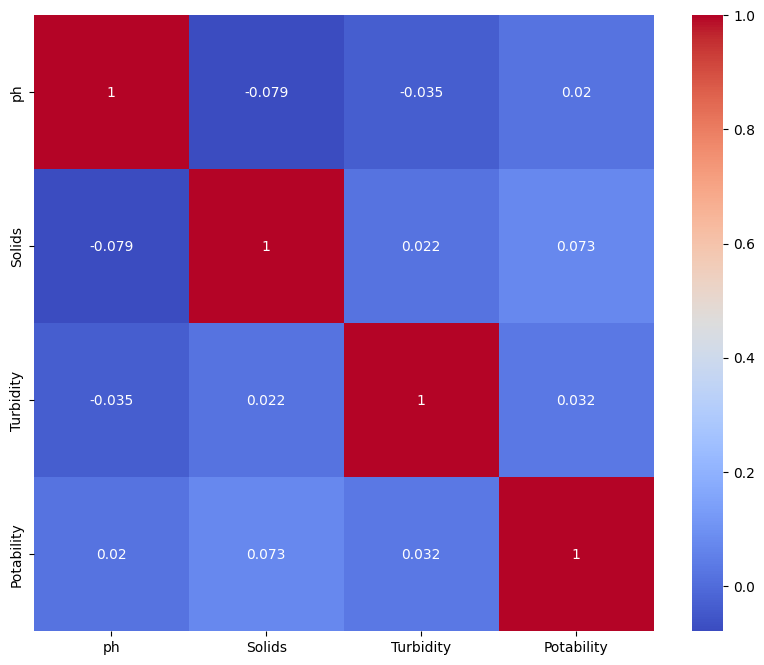

In [349]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

*   korelasi ph dengan potability: -0.0033
*   korelasi solids dengan potability: 0.034
*   korelasi turbidity dengan potability: 0.0016

Tidak Ada Fitur Dominan: Data ini menunjukkan bahwa tidak ada satu faktor tunggal yang secara langsung menentukan apakah air layak minum atau tidak. Kelayakan air tidak bisa ditebak hanya dengan melihat pH-nya saja atau kekeruhannya saja.

Kesimpulan untuk Pemilihan Model: Rendahnya nilai korelasi ini mengindikasikan bahwa hubungan antara fitur fisikokimia air dan kelayakannya bersifat Non-Linear dan Kompleks. Oleh karena itu, penggunaan algoritma linear (seperti Logistic Regression) kemungkinan besar akan memberikan akurasi yang buruk. Baiknya menggunakan algoritma berbasis Tree dan Ensemble seperti Random Forest atau XGBoost, karena algoritma ini mampu mempelajari pola non-linear yang rumit dari kombinasi banyak fitur sekaligus.

# **Training and Evaluation**

## Split data

In [350]:
x = df[['ph', 'Solids', 'Turbidity']]
print(x.columns)

y = df['Potability'] #cuma y yang hasilnya
print(x.shape, y.shape)

Index(['ph', 'Solids', 'Turbidity'], dtype='object')
(11286, 3) (11286,)


In [351]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)

(9028, 3) (9028,)


In [352]:
print(x_test.shape, y_test.shape)

(2258, 3) (2258,)


# Model Selection

In [353]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier , RandomForestClassifier 

In [354]:
models = {
    'Decision_Tree_Class' : DecisionTreeClassifier() , 
    'KNNClassifier' : KNeighborsClassifier(),
    'AdaBoostClassifier' : AdaBoostClassifier(),
    'RandomForestClassifier' : RandomForestClassifier(),
    'XGBClassifier' : XGBClassifier()
}

In [355]:
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
def evaluate_metrics(true , predict) : 
    accuracy = accuracy_score(true , predict)
    classrep = classification_report(true , predict)
    cf_matrix = confusion_matrix(true , predict)
    return accuracy , classrep , cf_matrix





------- Decision_Tree_Class


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7134632418069088
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.73      0.72      0.72      1183
           1       0.70      0.71      0.70      1075

    accuracy                           0.71      2258
   macro avg       0.71      0.71      0.71      2258
weighted avg       0.71      0.71      0.71      2258



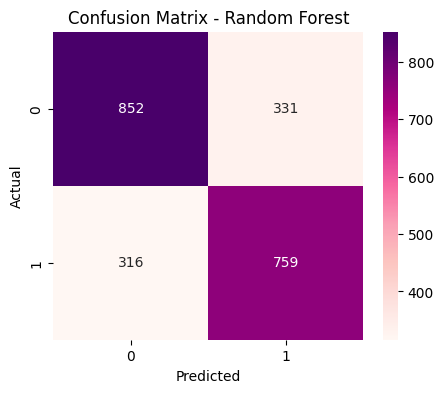





------- KNNClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7320637732506643
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.74      0.75      0.75      1183
           1       0.72      0.71      0.72      1075

    accuracy                           0.73      2258
   macro avg       0.73      0.73      0.73      2258
weighted avg       0.73      0.73      0.73      2258



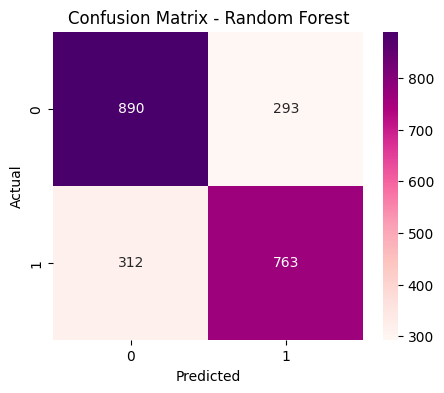





------- AdaBoostClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.75022143489814
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.74      0.80      0.77      1183
           1       0.76      0.70      0.73      1075

    accuracy                           0.75      2258
   macro avg       0.75      0.75      0.75      2258
weighted avg       0.75      0.75      0.75      2258



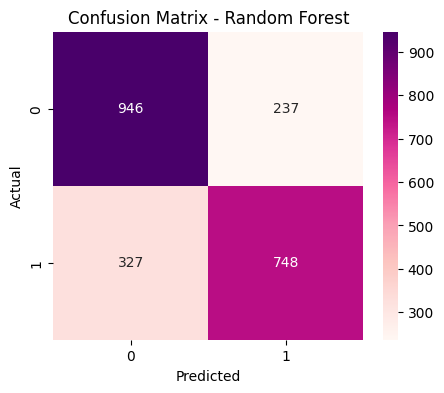





------- RandomForestClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7586359610274579
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.76      0.79      0.78      1183
           1       0.76      0.72      0.74      1075

    accuracy                           0.76      2258
   macro avg       0.76      0.76      0.76      2258
weighted avg       0.76      0.76      0.76      2258



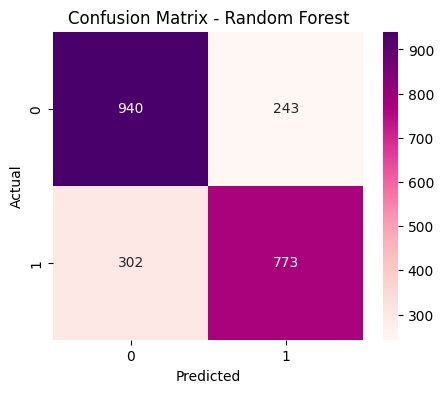





------- XGBClassifier


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

X TEST PREDS
ACCURACY 0.7604074402125776
 CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.76      0.79      0.78      1183
           1       0.76      0.73      0.74      1075

    accuracy                           0.76      2258
   macro avg       0.76      0.76      0.76      2258
weighted avg       0.76      0.76      0.76      2258



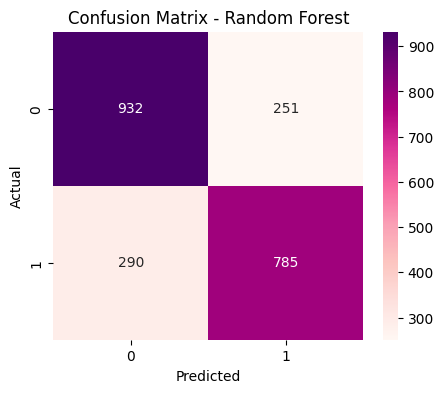

In [356]:
for i in range(len(models)) : 
    model = list(models.values())[i]
    model.fit(x_train , y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    accuracy_test , class_rep_test , cf_matrix_test = evaluate_metrics(y_test , y_pred_test)
    print('\n\n\n')
    print('-------',list(models.keys())[i])
    print('\n')
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
    print('X TEST PREDS')
    print(f'ACCURACY {accuracy_test}')
    print(' CLASSIFICATION REPORT \n'  , class_rep_test)
    plt.figure(figsize=(5,4))
    sns.heatmap(cf_matrix_test, annot=True, fmt='d', cmap='RdPu')
    plt.title("Confusion Matrix - Random Forest")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



In [357]:

model_rf = RandomForestClassifier(n_estimators=500,
    max_depth=8
    )
model_rf.fit(x_train, y_train)

model_xgb = XGBClassifier(n_estimators=200,
    max_depth=8,
    learning_rate=0.05)
model_xgb.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Akurasi Model: 76.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1183
           1       0.77      0.72      0.75      1075

    accuracy                           0.76      2258
   macro avg       0.76      0.76      0.76      2258
weighted avg       0.76      0.76      0.76      2258

Accuracy : 0.764
Precision: 0.7667
Recall   : 0.7247
F1 Score : 0.7451


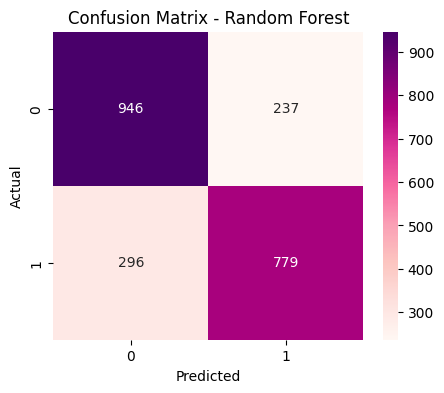

In [358]:
# Prediksi data test
y_pred_xgb = model_xgb.predict(x_test)

# Hitung Akurasi
acc_rf = accuracy_score(y_test, y_pred_xgb)
print(f"Akurasi Model: {acc_rf * 100:.2f}%")

# Tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1 Score :", round(f1, 4))

# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Akurasi Model: 77.68%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1183
           1       0.81      0.69      0.75      1075

    accuracy                           0.78      2258
   macro avg       0.78      0.77      0.77      2258
weighted avg       0.78      0.78      0.77      2258

Accuracy : 0.7768
Precision: 0.8127
Recall   : 0.6902
F1 Score : 0.7465


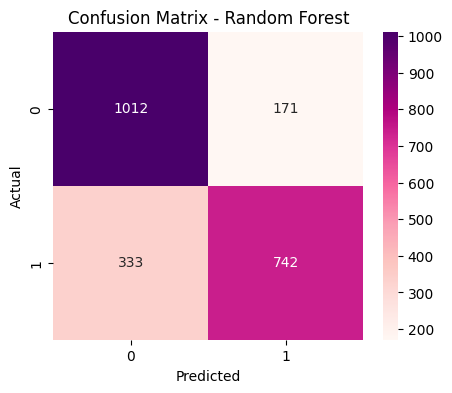

In [359]:
# Prediksi data test
y_pred_rf = model_rf.predict(x_test)

# Hitung Akurasi
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Akurasi Model: {acc_rf * 100:.2f}%")

# Tampilkan laporan lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1 Score :", round(f1, 4))

# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### **Tes rf model with Dummy data**

In [360]:
#1.buat dummy data (contoh: air dengan pH normal tapi solid tinggi)
data_baru = pd.DataFrame({
    'ph': [7.0, 4.5, 1.0, 3.0, 10.0],                # pH Netral
    'Solids': [200.0, 100.0, 230.0, 323.233,150.22],        # Padatan terlarut (agak tinggi)
    'Turbidity': [0.5, 0.8, 10.0, 2.1, 1.6] 
})

print("Data Baru (Mentah):")
print(data_baru)


# 2. prediksi
prediksi = model_rf.predict(data_baru)
probabilitas = model_rf.predict_proba(data_baru)

# 3. tampilkan Hasil
print("\n--- Hasil Prediksi ---")
for i in range(len(data_baru['Turbidity'])):
    print(f'prediksi data ke {i+1}')
    if prediksi[i] == 1:
        print(f"Hasil: 1 (LAYAK MINUM)")
    else:
        print(f"Hasil: 0 (TIDAK LAYAK MINUM)")
    print(f"Confidence (Keyakinan Model): {max(probabilitas[i]) * 100:.2f}%\n")

Data Baru (Mentah):
     ph   Solids  Turbidity
0   7.0  200.000        0.5
1   4.5  100.000        0.8
2   1.0  230.000       10.0
3   3.0  323.233        2.1
4  10.0  150.220        1.6

--- Hasil Prediksi ---
prediksi data ke 1
Hasil: 1 (LAYAK MINUM)
Confidence (Keyakinan Model): 53.36%

prediksi data ke 2
Hasil: 1 (LAYAK MINUM)
Confidence (Keyakinan Model): 71.80%

prediksi data ke 3
Hasil: 0 (TIDAK LAYAK MINUM)
Confidence (Keyakinan Model): 53.29%

prediksi data ke 4
Hasil: 0 (TIDAK LAYAK MINUM)
Confidence (Keyakinan Model): 63.89%

prediksi data ke 5
Hasil: 0 (TIDAK LAYAK MINUM)
Confidence (Keyakinan Model): 57.08%



# **Model**

In [361]:
#Pilih fitur utk regresi
x_final = df.drop('Potability', axis=1)
y_final = df['Potability'] #cuma y yang hasilnya

print(x_final)

# final Train
final_lm = RandomForestClassifier(n_estimators=500,
    max_depth=8
    )# Use the best performing model
final_lm.fit(x_final, y_final) #training the algorithm

# Lakukan prediksi pada data testing
y_pred = final_lm.predict(x_test)

             ph      Solids  Turbidity
0      7.160466  365.109446   3.991681
1      7.187738  342.952066   3.957064
2      5.400302  278.493442   4.824786
3      7.078913  347.406221   3.909317
4      7.052283  349.346270   3.989340
...         ...         ...        ...
13268  6.702547  278.176135   3.442983
13272  7.808856  279.512938   2.798243
13273  9.419510  534.767391   3.298875
13274  5.126763  193.288216   4.708658
13275  7.874671  280.712533   2.309149

[11286 rows x 3 columns]


In [362]:
# Define the filename for the saved model
model_filename = 'model/water_potability_model_v2.pkl'

# Save the trained model to the file
joblib.dump(final_lm, model_filename)

print(f"Trained model saved to {model_filename}")

Trained model saved to model/water_potability_model_v2.pkl
